In [1]:
import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.interpolate as scplt

In [2]:
options = {'display.max_rows': None, 
           'display.max_columns': None, 
           'display.max_colwidth': None}
for option, value in options.items():
    pd.set_option(option, value)

In [3]:
df = pd.read_csv('Data.csv')
df = df[['Week', 'Ad name'] + list(df.columns[2:])]
df = df.drop(columns = ['Result type','Link clicks', 'CPC (cost per link click)', 'CTR (link click-through rate)', 'Unique CTR (link click-through rate)'])
df = df.sort_values(by = ['Ad name', 'Week'])
df = df[['Week','Ad name','Unique clicks (all)','Unique CTR (all)','Clicks (all)','CTR (all)','CPC (All)','Website checkouts initiated','Landing page views','Cost per landing page view','Adds to cart','Cost per add to cart','Results','Cost per result','Amount spent (INR)','Reach','Impressions','Frequency','CPM (cost per 1,000 impressions)','Purchases conversion value','Reporting starts','Reporting ends']].reset_index(drop = True)
df.style.hide(axis = 'index')

Week,Ad name,Unique clicks (all),Unique CTR (all),Clicks (all),CTR (all),CPC (All),Website checkouts initiated,Landing page views,Cost per landing page view,Adds to cart,Cost per add to cart,Results,Cost per result,Amount spent (INR),Reach,Impressions,Frequency,"CPM (cost per 1,000 impressions)",Purchases conversion value,Reporting starts,Reporting ends
2022-01-01 - 2022-01-07,60minShubhamHindi,984,1.077400,1214,0.911637,8.129069,171.000000,581.000000,16.985697,158.000000,62.460063,3.000000,3289.563330,9868.690000,91331,133167,1.458070,74.107624,1497.000000,01/01/22,07/01/22
2022-01-08 - 2022-01-14,60minShubhamHindi,887,0.877176,1089,0.834617,7.457282,170.000000,514.000000,15.799572,154.000000,52.733636,7.000000,1160.140000,8120.980000,101120,130479,1.290338,62.239747,3493.000000,08/01/22,14/01/22
2022-01-15 - 2022-01-21,60minShubhamHindi,1184,0.966326,1442,0.876313,6.305028,268.000000,716.000000,12.698115,240.000000,37.882708,11.000000,826.531818,9091.850000,122526,164553,1.343005,55.251803,5489.000000,15/01/22,21/01/22
2022-01-22 - 2022-01-28,60minShubhamHindi,641,0.962679,812,0.945858,5.754778,140.000000,402.000000,11.624080,133.000000,35.134436,1.000000,4672.880000,4672.880000,66585,85848,1.289299,54.432019,499.000000,22/01/22,28/01/22
2022-01-29 - 2022-02-04,60minShubhamHindi,810,0.905544,1003,0.839963,6.403350,109.000000,480.000000,13.380333,106.000000,60.590189,3.000000,2140.853330,6422.560000,89449,119410,1.334951,53.785780,1497.000000,29/01/22,04/02/22
2022-02-05 - 2022-02-11,60minShubhamHindi,61,1.120705,73,1.295475,7.810411,11.000000,34.000000,16.769412,11.000000,51.832727,nan,nan,570.160000,5443,5635,1.035275,101.181899,nan,05/02/22,11/02/22
2022-03-19 - 2022-03-25,60minShubhamHindi,304,0.958174,342,0.830641,12.816901,25.000000,175.000000,25.047886,19.000000,230.704211,4.000000,1095.845000,4383.380000,31727,41173,1.297727,106.462488,1996.000000,19/03/22,25/03/22
2022-03-26 - 2022-04-01,60minShubhamHindi,3103,0.972797,3575,0.726149,13.961902,184.000000,1103.000000,45.252765,145.000000,344.233103,18.000000,2772.988890,49913.800000,318977,492323,1.543444,101.384254,8982.000000,26/03/22,01/04/22
2022-04-02 - 2022-04-08,60minShubhamHindi,2971,0.793263,3497,0.548429,17.369665,224.000000,1284.000000,47.306635,172.000000,353.149535,33.000000,1840.658180,60741.720000,374529,637640,1.702512,95.260210,14969.000000,02/04/22,08/04/22
2022-04-09 - 2022-04-15,60minShubhamHindi,2957,0.732593,3470,0.537044,15.697453,166.000000,1228.000000,44.356808,132.000000,412.652727,14.000000,3890.725710,54470.160000,403635,646129,1.600775,84.302299,6986.000000,09/04/22,15/04/22


In [5]:
df.columns

Index(['Week', 'Ad name', 'Unique clicks (all)', 'Unique CTR (all)',
       'Clicks (all)', 'CTR (all)', 'CPC (All)', 'Website checkouts initiated',
       'Landing page views', 'Cost per landing page view', 'Adds to cart',
       'Cost per add to cart', 'Results', 'Cost per result',
       'Amount spent (INR)', 'Reach', 'Impressions', 'Frequency',
       'CPM (cost per 1,000 impressions)', 'Purchases conversion value',
       'Reporting starts', 'Reporting ends'],
      dtype='object')

In [6]:
ad_index = df['Ad name'].unique()
ad_index = {i : ad_index[i] for i in range(len(ad_index))}
ad_index

{0: '60minShubhamHindi',
 1: 'Ad1-Carousel',
 2: 'Ad1-GifVideo',
 3: 'AvoidingPresentation_La_SingleImage',
 4: 'BetterEngFour',
 5: 'DirtySecret_SingleImage',
 6: 'EnglishKamjori_La_SingleImage',
 7: 'FluencySecret_La_SingleImage',
 8: 'Girl JobReadyXBBREnglish499Demo',
 9: 'Hardwork_SingleImage'}

In [7]:
week_count = df[['Ad name', 'Week']].groupby('Ad name').count().rename(columns = {'Week': 'Weeks'})
week_count

,Weeks
Ad name,
60minShubhamHindi,11
Ad1-Carousel,4
Ad1-GifVideo,4
AvoidingPresentation_La_SingleImage,7
BetterEngFour,3
DirtySecret_SingleImage,1
EnglishKamjori_La_SingleImage,9
FluencySecret_La_SingleImage,12
Girl JobReadyXBBREnglish499Demo,11


### Finding duplicate & ambigious values

In [8]:
new = df[df.duplicated(subset = ['Ad name', 'Week'], keep = False)].set_index(['Ad name', 'Week'], append = True)
new.index = new.set_index(new.index.levels[0], append = True).index.droplevel()
new = new.sort_values(by = ['Ad name','Week'])
new = new.rename_axis(index = {None : 'idx'})
new.style.format(precision = 4)

### Some rows have 0 reach and 0 impressions so dropping them

In [9]:
df = df[df['Reach'] != 0]

### Total unique clicks for each ad (estimating audience)

In [10]:
users = df[['Ad name', 'Unique clicks (all)']].groupby('Ad name').sum().sort_values(by = 'Unique clicks (all)', ascending = False)
users

,Unique clicks (all)
Ad name,
60minShubhamHindi,14683
FluencySecret_La_SingleImage,5120
Girl JobReadyXBBREnglish499Demo,4549
Ad1-GifVideo,3454
Ad1-Carousel,3248
BetterEngFour,2422
EnglishKamjori_La_SingleImage,1926
AvoidingPresentation_La_SingleImage,971
Hardwork_SingleImage,106


### Weekly results/unique clicks (%) - how much of a targeted audience are the ads approaching

In [11]:
sample = df.loc[:,['Ad name', 'Week', 'Results', 'Unique clicks (all)']].copy().fillna(0).sort_values(by = 'Week')
sample = sample.assign(result = lambda x : x['Results']/x['Unique clicks (all)'] * 100).groupby(by = ['Ad name', 'Week']).mean()
sample['result'].unstack(level = 1).style.format(precision = 4)

Week,2022-01-01 - 2022-01-07,2022-01-08 - 2022-01-14,2022-01-15 - 2022-01-21,2022-01-22 - 2022-01-28,2022-01-29 - 2022-02-04,2022-02-05 - 2022-02-11,2022-02-12 - 2022-02-18,2022-02-19 - 2022-02-25,2022-02-26 - 2022-03-04,2022-03-05 - 2022-03-11,2022-03-12 - 2022-03-18,2022-03-19 - 2022-03-25,2022-03-26 - 2022-04-01,2022-04-02 - 2022-04-08,2022-04-09 - 2022-04-15,2022-04-16 - 2022-04-18
Ad name,,,,,,,,,,,,,,,,
60minShubhamHindi,0.3049,0.7892,0.9291,0.1560,0.3704,0.0000,nan,nan,nan,nan,nan,1.3158,0.5801,1.1107,0.4735,0.7682
Ad1-Carousel,nan,nan,nan,nan,nan,nan,0.5059,0.3655,0.0000,2.2222,nan,nan,nan,nan,nan,nan
Ad1-GifVideo,nan,nan,nan,nan,nan,nan,0.0000,0.2954,0.3247,0.0000,nan,nan,nan,nan,nan,nan
AvoidingPresentation_La_SingleImage,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,1.0638,1.6048,0.2747,nan,nan,nan
BetterEngFour,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,1.3793,1.6049,0.7610
DirtySecret_SingleImage,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.0000,nan,nan,nan,nan,nan,nan
EnglishKamjori_La_SingleImage,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.5929,0.9419,0.1792,0.0000,nan,nan,nan
FluencySecret_La_SingleImage,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.8097,0.6040,0.7655,0.3825,0.7564,1.4706,6.0606
Girl JobReadyXBBREnglish499Demo,0.7117,0.7299,0.6380,0.4608,0.2361,2.8571,nan,nan,nan,nan,nan,0.7463,0.2000,1.6878,0.0000,1.3158


### Ranking ( based on results/unique clicks %)

In [12]:
t = sample['result'].groupby('Ad name').mean().sort_values(ascending = False)
t = pd.DataFrame({'Average' : t})
t.style.format("{:,.4f} %")

,Average
Ad name,
FluencySecret_La_SingleImage,1.5499 %
BetterEngFour,1.2484 %
AvoidingPresentation_La_SingleImage,0.9811 %
Girl JobReadyXBBREnglish499Demo,0.8712 %
Ad1-Carousel,0.7734 %
60minShubhamHindi,0.6180 %
EnglishKamjori_La_SingleImage,0.4285 %
Ad1-GifVideo,0.1550 %
DirtySecret_SingleImage,0.0000 %


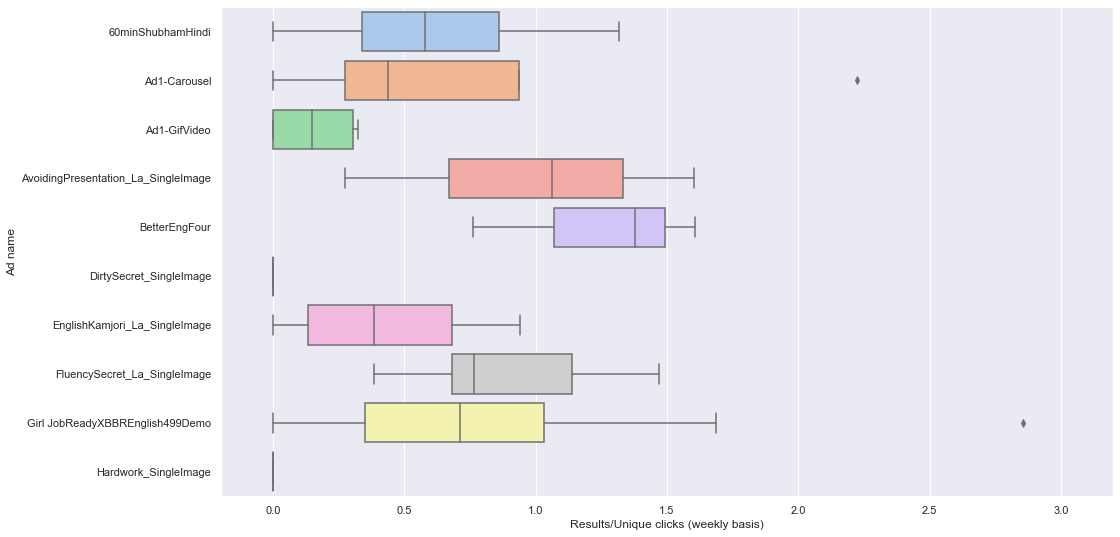

In [14]:
for_plot = sample.reset_index()[['Ad name', 'result']]
sns.set(palette = 'pastel')
ax = sns.boxplot(y = 'Ad name', x = 'result', data = for_plot)
plt.xlabel('Results/Unique clicks (weekly basis)')
plt.xlim(-0.2,3.2)
sns.set(rc = {'figure.figsize':(16,9)})

#### Although average value of 'FluencySecret_La_SingleImage' is highest but the boxplots show that its median is not that high so ranking again based on medians

In [15]:
res_per_cl = sample['result'].groupby(['Ad name']).median().sort_values(ascending = False)
res_per_cl = pd.DataFrame({'Median Results/Unique Clicks' : res_per_cl})
res_per_cl.style.format("{:,.4f} %")

,Median Results/Unique Clicks
Ad name,
BetterEngFour,1.3793 %
AvoidingPresentation_La_SingleImage,1.0638 %
FluencySecret_La_SingleImage,0.7655 %
Girl JobReadyXBBREnglish499Demo,0.7117 %
60minShubhamHindi,0.5801 %
Ad1-Carousel,0.4357 %
EnglishKamjori_La_SingleImage,0.3860 %
Ad1-GifVideo,0.1477 %
DirtySecret_SingleImage,0.0000 %


### Ranking Various Ratios (based on median)

In [30]:
sample = df.loc[:,['Ad name', 'Week', 'Adds to cart', 'Landing page views', 'Unique clicks (all)']]\
            .copy().fillna(0).sort_values(by = 'Week')
sample = sample.assign(atc = lambda x : x['Adds to cart']/x['Unique clicks (all)'] * 100\
                       , lpw = lambda x : x['Landing page views']/x['Unique clicks (all)'] * 100)
sample = sample.groupby(['Ad name', 'Week']).mean().unstack(level = 1)
midx = pd.IndexSlice
sample = sample.loc[:, midx[['lpw', 'atc'],:]]
sample = sample.stack().groupby('Ad name').median()
per_unique_clicks = pd.concat([sample,res_per_cl], axis = 1)
per_unique_clicks.rename(columns = {'lpw' : 'Landing Page Views',\
                                    'atc' : 'Adds to cart',\
                                    'Median Results/Unique Clicks' : 'Results'}, inplace = True)
per_unique_clicks.rename_axis(columns = {None : 'Median per unique clicks'}, inplace = True)
per_unique_clicks = per_unique_clicks.iloc[:,[2,0,1]]
per_unique_clicks.sort_values(by = ['Results', 'Adds to cart'], ascending = False, inplace = True)
# per_unique_clicks.style.background_gradient(cmap='Blues')\
#                  .set_caption('Heatmap along with values (darker color indicates higher values)')\
#                  .format(precision = 4)
per_unique_clicks.style.format("{:.4f} %")

Median per unique clicks,Results,Adds to cart,Landing Page Views
Ad name,,,
BetterEngFour,1.3793 %,6.3927 %,40.1826 %
AvoidingPresentation_La_SingleImage,1.0638 %,5.1604 %,49.6287 %
FluencySecret_La_SingleImage,0.7655 %,5.6470 %,39.2571 %
Girl JobReadyXBBREnglish499Demo,0.7117 %,6.5789 %,38.1068 %
60minShubhamHindi,0.5801 %,13.0864 %,57.5658 %
Ad1-Carousel,0.4357 %,2.5942 %,37.4500 %
EnglishKamjori_La_SingleImage,0.3860 %,5.2865 %,35.2659 %
Ad1-GifVideo,0.1477 %,5.5750 %,36.2632 %
Hardwork_SingleImage,0.0000 %,1.8868 %,39.6226 %


### Overall values of various things

In [29]:
oall = df.groupby('Ad name').agg({'Unique clicks (all)' : ['sum', 'mean'],
                           'Unique CTR (all)' : ['mean', 'median'],
                           'Frequency' : 'mean',
                           'Results' : ['sum', 'mean'],
                           'Amount spent (INR)' : ['sum', 'mean'],
                           'Purchases conversion value' : ['sum', 'mean'],
                           'Cost per result' : 'mean'})
oall = oall.sort_values(by = ('Unique clicks (all)','sum'), ascending = False)
oall = pd.concat([oall.T, oall.mean()], axis = 1).rename(columns = {0:'Average'}).T
cm = sns.diverging_palette(-5, 5, as_cmap=True)
# oall.style.background_gradient(cmap='Blues', subset = (oall.index[0:-1],oall.columns))\
#     .set_caption('Heatmap along with values (darker color indicates higher values)')\
#     .background_gradient(cmap = cm, subset = (oall.index[-1], oall.columns))
oall.style.format(precision=4)

## Weekly Analysis

#### For Reference
- 0: '60minShubhamHindi',
- 1: 'Ad1-Carousel',
- 2: 'Ad1-GifVideo',
- 3: 'AvoidingPresentation_La_SingleImage',
- 4: 'BetterEngFour',
- 5: 'DirtySecret_SingleImage',
- 6: 'EnglishKamjori_La_SingleImage',
- 7: 'FluencySecret_La_SingleImage',
- 8: 'Girl JobReadyXBBREnglish499Demo',
- 9: 'Hardwork_SingleImage'

In [18]:
# Ads to perform Anyalysis on
req_col = list(range(10))

### Unique CTR (all)

In [27]:
uctr = df.groupby(['Ad name', 'Week']).mean()['Unique CTR (all)'].unstack(level = 1)
uctr.assign(Median = lambda x : x.median(axis = 1) ,Average = lambda x : x.mean(axis = 1)).style\
    .format({'Median' : "{:,.4f}%", 'Average' : "{:,.4f}%"}, precision=4)

Week,2022-01-01 - 2022-01-07,2022-01-08 - 2022-01-14,2022-01-15 - 2022-01-21,2022-01-22 - 2022-01-28,2022-01-29 - 2022-02-04,2022-02-05 - 2022-02-11,2022-02-12 - 2022-02-18,2022-02-19 - 2022-02-25,2022-02-26 - 2022-03-04,2022-03-05 - 2022-03-11,2022-03-12 - 2022-03-18,2022-03-19 - 2022-03-25,2022-03-26 - 2022-04-01,2022-04-02 - 2022-04-08,2022-04-09 - 2022-04-15,2022-04-16 - 2022-04-18,Median,Average
Ad name,,,,,,,,,,,,,,,,,,
60minShubhamHindi,1.0774,0.8772,0.9663,0.9627,0.9055,1.1207,nan,nan,nan,nan,nan,0.9582,0.9728,0.7933,0.7326,0.6681,0.9582%,0.9161%
Ad1-Carousel,nan,nan,nan,nan,nan,nan,0.5690,0.5418,0.5218,0.5024,nan,nan,nan,nan,nan,nan,0.5318%,0.5334%
Ad1-GifVideo,nan,nan,nan,nan,nan,nan,1.0262,0.9429,0.8637,1.2495,nan,nan,nan,nan,nan,nan,0.9845%,1.0133%
AvoidingPresentation_La_SingleImage,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.9430,1.0540,0.6470,nan,nan,nan,0.9430%,0.8967%
BetterEngFour,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,1.2751,1.5309,1.1964,1.2751%,1.3194%
DirtySecret_SingleImage,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.4510,nan,nan,nan,nan,nan,nan,0.4510%,0.4510%
EnglishKamjori_La_SingleImage,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.6454,0.7815,0.6966,0.3450,nan,nan,nan,0.6710%,0.6279%
FluencySecret_La_SingleImage,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.7414,1.0435,1.0330,0.7392,0.9840,1.3428,1.1502,1.0330%,1.0084%
Girl JobReadyXBBREnglish499Demo,0.5051,0.5016,0.4852,0.5213,0.5880,0.4027,nan,nan,nan,nan,nan,0.6033,0.5805,0.5186,0.6354,0.5146,0.5186%,0.5312%


Median Val -  0.74144116


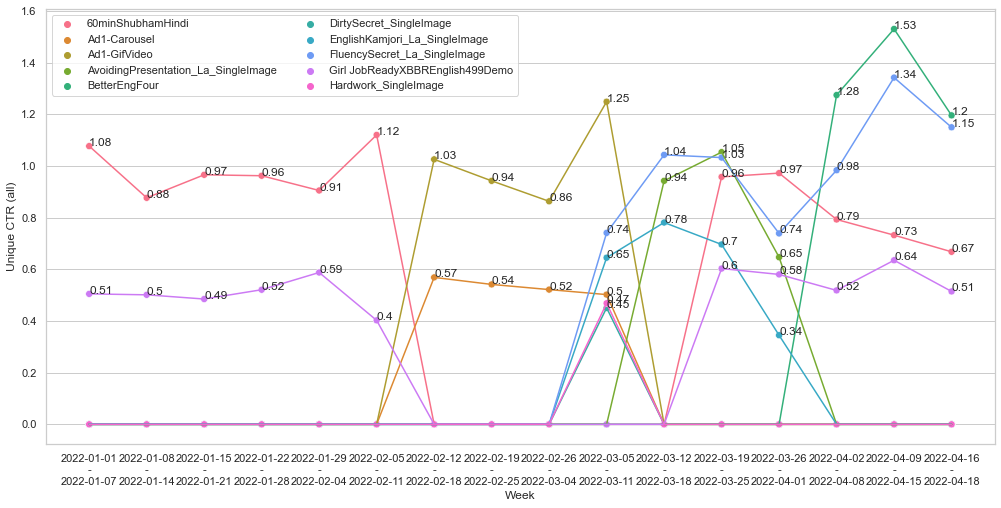

In [29]:
print("Median Val - ", uctr.stack().median())
uctrp = uctr.fillna(0).reset_index().melt('Ad name', var_name = 'Week', value_name = 'Value')
uctrp['Week'] = uctrp['Week'].apply(lambda x : x.replace(" ", "\n"))
_=uctrp[uctrp['Ad name'].isin([ad_index[i] for i in req_col])]
plt.grid(visible=None, axis = 'x')
sns.lineplot(data = _, x = 'Week', y = 'Value', hue = 'Ad name', legend = False)
sns.scatterplot(data = _, x = 'Week', y = 'Value', hue = 'Ad name', s = 50)
for name, week, value in zip(_['Ad name'], _['Week'], _['Value']):
    if value > 0:
        plt.text(week, value, round(value,2))
sns.set(rc = {'figure.figsize':(17,8)}, palette = "hls")
sns.set_style("whitegrid")
plt.ylabel('Unique CTR (all)')
plt.legend(ncol = 2)
plt.show()

### Landing Page Views

In [19]:
lpv = df.groupby(['Ad name', 'Week']).sum()['Landing page views'].unstack(level = 1)
lpv.assign(Median = lambda x : x.median(axis = 1) ,Average = lambda x : x.mean(axis = 1)).style.format(precision = 2)

Week,2022-01-01 - 2022-01-07,2022-01-08 - 2022-01-14,2022-01-15 - 2022-01-21,2022-01-22 - 2022-01-28,2022-01-29 - 2022-02-04,2022-02-05 - 2022-02-11,2022-02-12 - 2022-02-18,2022-02-19 - 2022-02-25,2022-02-26 - 2022-03-04,2022-03-05 - 2022-03-11,2022-03-12 - 2022-03-18,2022-03-19 - 2022-03-25,2022-03-26 - 2022-04-01,2022-04-02 - 2022-04-08,2022-04-09 - 2022-04-15,2022-04-16 - 2022-04-18,Median,Average
Ad name,,,,,,,,,,,,,,,,,,
60minShubhamHindi,581.00,514.00,716.00,402.00,480.00,34.00,nan,nan,nan,nan,nan,175.00,1103.00,1284.00,1228.00,334.00,514.00,613.75
Ad1-Carousel,nan,nan,nan,nan,nan,nan,255.00,649.00,258.00,17.00,nan,nan,nan,nan,nan,nan,256.50,287.10
Ad1-GifVideo,nan,nan,nan,nan,nan,nan,59.00,517.00,347.00,27.00,nan,nan,nan,nan,nan,nan,203.00,230.60
AvoidingPresentation_La_SingleImage,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,46.00,239.00,111.00,nan,nan,nan,111.00,126.75
BetterEngFour,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,36.00,728.00,264.00,264.00,323.00
DirtySecret_SingleImage,nan,nan,nan,nan,nan,nan,nan,nan,nan,7.00,nan,nan,nan,nan,nan,nan,7.00,7.00
EnglishKamjori_La_SingleImage,nan,nan,nan,nan,nan,nan,nan,nan,nan,212.00,258.00,151.00,29.00,nan,nan,nan,181.50,166.30
FluencySecret_La_SingleImage,nan,nan,nan,nan,nan,nan,nan,nan,nan,198.00,310.00,426.00,357.00,221.00,69.00,18.00,221.00,227.50
Girl JobReadyXBBREnglish499Demo,298.00,332.00,345.00,242.00,403.00,12.00,nan,nan,nan,nan,nan,34.00,77.00,71.00,157.00,27.00,157.00,179.58


Median Val -  242.0


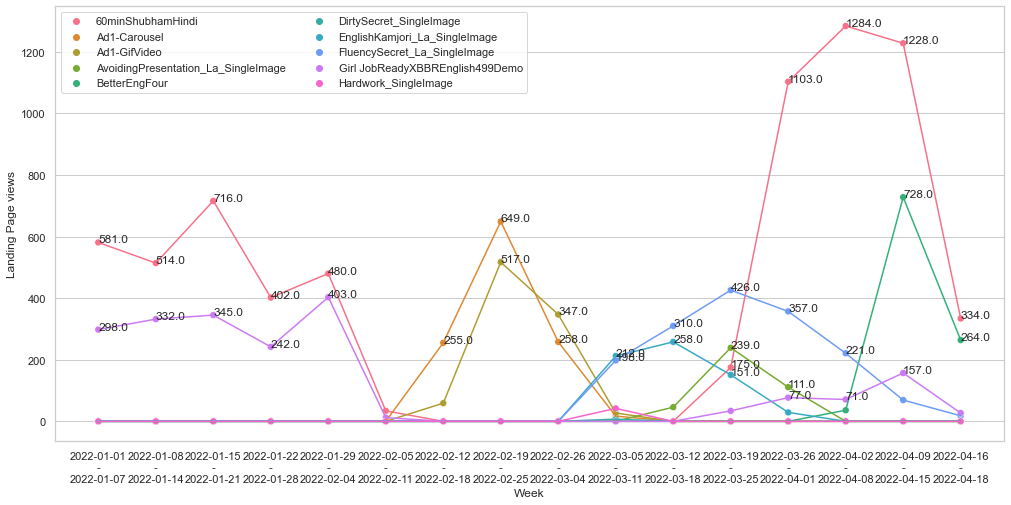

In [20]:
print("Median Val - ", lpv.stack().median())
lpvp = lpv.fillna(0).reset_index().melt('Ad name', var_name = 'Week', value_name = 'Value')
lpvp['Week'] = lpvp['Week'].apply(lambda x : x.replace(" ", "\n"))
_=lpvp[lpvp['Ad name'].isin([ad_index[i] for i in req_col])]
plt.grid(visible=None, axis = 'x')
sns.lineplot(data = _, x = 'Week', y = 'Value', hue = 'Ad name', legend = False)
sns.scatterplot(data = _, x = 'Week', y = 'Value', hue = 'Ad name', s = 50)
for name, week, value in zip(_['Ad name'], _['Week'], _['Value']):
    if value >= 70:
        plt.text(week, value, round(value,2))
sns.set(rc = {'figure.figsize':(17,8)}, palette = "hls")
sns.set_style("whitegrid")
plt.ylabel('Landing Page views')
plt.legend(ncol = 2)
plt.show()

### Adds to cart

In [21]:
atcs = df.groupby(['Ad name', 'Week']).sum()['Adds to cart'].unstack(level = 1)
atcs.assign(Median = lambda x : x.median(axis = 1) ,Average = lambda x : x.mean(axis = 1)).style.format(precision = 2)

Week,2022-01-01 - 2022-01-07,2022-01-08 - 2022-01-14,2022-01-15 - 2022-01-21,2022-01-22 - 2022-01-28,2022-01-29 - 2022-02-04,2022-02-05 - 2022-02-11,2022-02-12 - 2022-02-18,2022-02-19 - 2022-02-25,2022-02-26 - 2022-03-04,2022-03-05 - 2022-03-11,2022-03-12 - 2022-03-18,2022-03-19 - 2022-03-25,2022-03-26 - 2022-04-01,2022-04-02 - 2022-04-08,2022-04-09 - 2022-04-15,2022-04-16 - 2022-04-18,Median,Average
Ad name,,,,,,,,,,,,,,,,,,
60minShubhamHindi,158.00,154.00,240.00,133.00,106.00,11.00,nan,nan,nan,nan,nan,19.00,145.00,172.00,132.00,53.00,133.00,121.33
Ad1-Carousel,nan,nan,nan,nan,nan,nan,19.00,38.00,8.00,2.00,nan,nan,nan,nan,nan,nan,13.50,16.10
Ad1-GifVideo,nan,nan,nan,nan,nan,nan,9.00,62.00,54.00,4.00,nan,nan,nan,nan,nan,nan,31.50,32.10
AvoidingPresentation_La_SingleImage,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,4.00,21.00,4.00,nan,nan,nan,4.00,8.25
BetterEngFour,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,8.00,116.00,42.00,42.00,52.00
DirtySecret_SingleImage,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.00,nan,nan,nan,nan,nan,nan,0.00,0.00
EnglishKamjori_La_SingleImage,nan,nan,nan,nan,nan,nan,nan,nan,nan,42.00,48.00,19.00,2.00,nan,nan,nan,30.50,28.30
FluencySecret_La_SingleImage,nan,nan,nan,nan,nan,nan,nan,nan,nan,25.00,51.00,67.00,56.00,32.00,12.00,5.00,32.00,35.00
Girl JobReadyXBBREnglish499Demo,63.00,95.00,67.00,52.00,74.00,1.00,nan,nan,nan,nan,nan,1.00,5.00,8.00,9.00,5.00,9.00,32.42


Median Val -  32.0


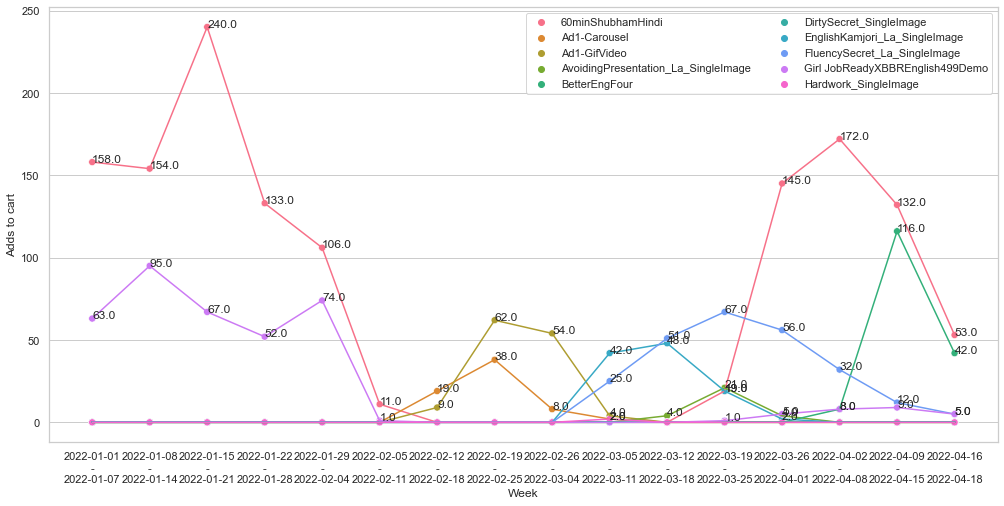

In [22]:
print("Median Val - ", atcs.stack().median())
atcp = atcs.fillna(0).reset_index().melt('Ad name', var_name = 'Week', value_name = 'Value')
atcp['Week'] = atcp['Week'].apply(lambda x : x.replace(" ", "\n"))
_=atcp[atcp['Ad name'].isin([ad_index[i] for i in req_col])]
plt.grid(visible=None, axis = 'x')
sns.lineplot(data = _, x = 'Week', y = 'Value', hue = 'Ad name', legend = False)
sns.scatterplot(data = _, x = 'Week', y = 'Value', hue = 'Ad name', s = 50)
for name, week, value in zip(_['Ad name'], _['Week'], _['Value']):
    if value > 0:
        plt.text(week, value, round(value,2))
sns.set(rc = {'figure.figsize':(17,8)}, palette = "hls")
sns.set_style("whitegrid")
plt.ylabel('Adds to cart')
plt.legend(ncol = 2)
plt.show()

### Results

In [23]:
rs = df.groupby(['Ad name', 'Week']).sum()['Results'].unstack(level = 1)
rs.assign(Median = lambda x : x.median(axis = 1) ,Average = lambda x : x.mean(axis = 1)).style.format(precision = 2)

Week,2022-01-01 - 2022-01-07,2022-01-08 - 2022-01-14,2022-01-15 - 2022-01-21,2022-01-22 - 2022-01-28,2022-01-29 - 2022-02-04,2022-02-05 - 2022-02-11,2022-02-12 - 2022-02-18,2022-02-19 - 2022-02-25,2022-02-26 - 2022-03-04,2022-03-05 - 2022-03-11,2022-03-12 - 2022-03-18,2022-03-19 - 2022-03-25,2022-03-26 - 2022-04-01,2022-04-02 - 2022-04-08,2022-04-09 - 2022-04-15,2022-04-16 - 2022-04-18,Median,Average
Ad name,,,,,,,,,,,,,,,,,,
60minShubhamHindi,3.00,7.00,11.00,1.00,3.00,0.00,nan,nan,nan,nan,nan,4.00,18.00,33.00,14.00,6.00,6.00,8.83
Ad1-Carousel,nan,nan,nan,nan,nan,nan,3.00,7.00,0.00,1.00,nan,nan,nan,nan,nan,nan,2.00,2.60
Ad1-GifVideo,nan,nan,nan,nan,nan,nan,0.00,6.00,4.00,0.00,nan,nan,nan,nan,nan,nan,2.00,2.40
AvoidingPresentation_La_SingleImage,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,1.00,7.00,1.00,nan,nan,nan,1.00,2.50
BetterEngFour,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,2.00,26.00,5.00,5.00,9.50
DirtySecret_SingleImage,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.00,nan,nan,nan,nan,nan,nan,0.00,0.00
EnglishKamjori_La_SingleImage,nan,nan,nan,nan,nan,nan,nan,nan,nan,3.00,7.00,1.00,0.00,nan,nan,nan,2.00,2.60
FluencySecret_La_SingleImage,nan,nan,nan,nan,nan,nan,nan,nan,nan,4.00,4.00,9.00,7.00,10.00,2.00,2.00,4.00,5.25
Girl JobReadyXBBREnglish499Demo,4.00,5.00,4.00,2.00,2.00,1.00,nan,nan,nan,nan,nan,1.00,1.00,4.00,0.00,1.00,2.00,2.25


Median Val -  3.0


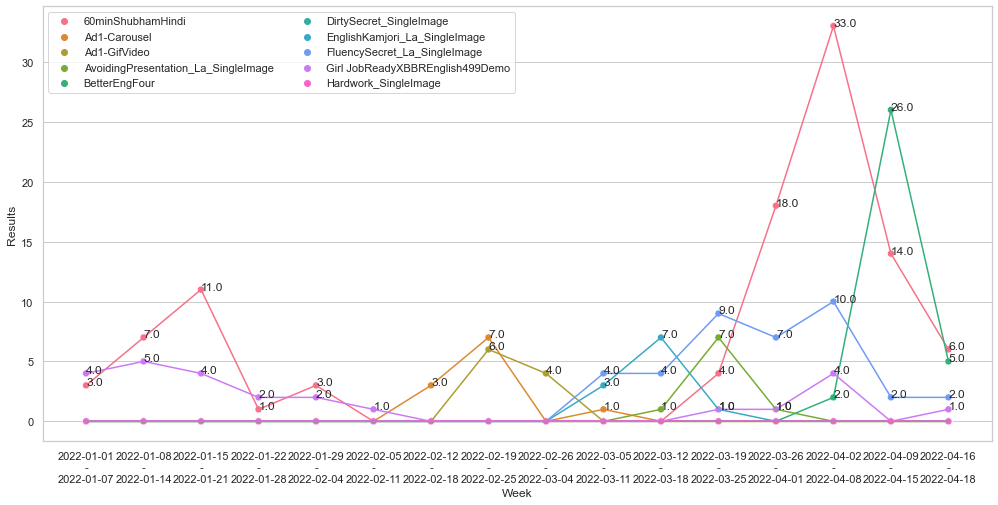

In [24]:
print("Median Val - ", rs.stack().median())
rsp = rs.fillna(0).reset_index().melt('Ad name', var_name = 'Week', value_name = 'Value')
rsp['Week'] = rsp['Week'].apply(lambda x : x.replace(" ", "\n"))
_=rsp[rsp['Ad name'].isin([ad_index[i] for i in req_col])]
plt.grid(visible=None, axis = 'x')
sns.lineplot(data = _, x = 'Week', y = 'Value', hue = 'Ad name', legend = False)
sns.scatterplot(data = _, x = 'Week', y = 'Value', hue = 'Ad name', s = 50)
for name, week, value in zip(_['Ad name'], _['Week'], _['Value']):
    if value > 0:
        plt.text(week, value, round(value,2))
sns.set(rc = {'figure.figsize':(17,8)}, palette = "hls")
sns.set_style("whitegrid")
plt.ylabel('Results')
plt.legend(ncol = 2)
plt.show()

### Frequency

In [25]:
fq = df.groupby(['Ad name', 'Week']).sum()['Frequency'].unstack(level = 1)
fq.assign(Median = lambda x : x.median(axis = 1) ,Average = lambda x : x.mean(axis = 1)).style.format(precision = 2)

Week,2022-01-01 - 2022-01-07,2022-01-08 - 2022-01-14,2022-01-15 - 2022-01-21,2022-01-22 - 2022-01-28,2022-01-29 - 2022-02-04,2022-02-05 - 2022-02-11,2022-02-12 - 2022-02-18,2022-02-19 - 2022-02-25,2022-02-26 - 2022-03-04,2022-03-05 - 2022-03-11,2022-03-12 - 2022-03-18,2022-03-19 - 2022-03-25,2022-03-26 - 2022-04-01,2022-04-02 - 2022-04-08,2022-04-09 - 2022-04-15,2022-04-16 - 2022-04-18,Median,Average
Ad name,,,,,,,,,,,,,,,,,,
60minShubhamHindi,1.46,1.29,1.34,1.29,1.33,1.04,nan,nan,nan,nan,nan,1.30,1.54,1.70,1.60,1.26,1.33,1.37
Ad1-Carousel,nan,nan,nan,nan,nan,nan,1.17,1.61,1.61,1.08,nan,nan,nan,nan,nan,nan,1.39,1.37
Ad1-GifVideo,nan,nan,nan,nan,nan,nan,1.18,1.46,2.30,1.28,nan,nan,nan,nan,nan,nan,1.37,1.52
AvoidingPresentation_La_SingleImage,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,2.25,3.77,1.11,nan,nan,nan,2.25,2.35
BetterEngFour,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,1.06,2.02,1.45,1.45,1.49
DirtySecret_SingleImage,nan,nan,nan,nan,nan,nan,nan,nan,nan,1.73,nan,nan,nan,nan,nan,nan,1.73,1.73
EnglishKamjori_La_SingleImage,nan,nan,nan,nan,nan,nan,nan,nan,nan,1.57,3.69,3.85,1.15,nan,nan,nan,2.63,2.58
FluencySecret_La_SingleImage,nan,nan,nan,nan,nan,nan,nan,nan,nan,1.47,3.75,4.13,1.46,2.72,1.56,1.21,1.56,2.23
Girl JobReadyXBBREnglish499Demo,1.26,1.24,1.24,1.17,1.25,1.03,nan,nan,nan,nan,nan,1.20,1.11,1.28,1.31,1.11,1.24,1.20


Median Val -  1.33495064


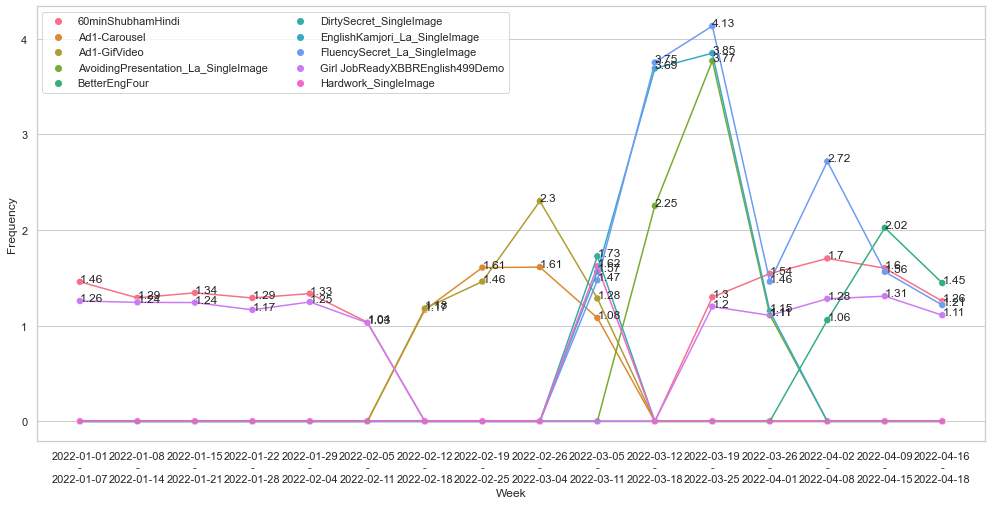

In [26]:
print("Median Val - ", fq.stack().median())
fqp = fq.fillna(0).reset_index().melt('Ad name', var_name = 'Week', value_name = 'Value')
fqp['Week'] = fqp['Week'].apply(lambda x : x.replace(" ", "\n"))
_=fqp[fqp['Ad name'].isin([ad_index[i] for i in req_col])]
plt.grid(visible=None, axis = 'x')
sns.lineplot(data = _, x = 'Week', y = 'Value', hue = 'Ad name', legend = False)
sns.scatterplot(data = _, x = 'Week', y = 'Value', hue = 'Ad name', s = 50)
for name, week, value in zip(_['Ad name'], _['Week'], _['Value']):
    if value > 0:
        plt.text(week, value, round(value,2))
sns.set(rc = {'figure.figsize':(17,8)}, palette = "hls")
sns.set_style("whitegrid")
plt.ylabel('Frequency')
plt.legend(ncol = 2)
plt.show()

### CAC

In [27]:
cac = df.groupby(['Ad name', 'Week']).sum()['Cost per result'].unstack(level = 1)
cac.assign(Median = lambda x : x.median(axis = 1) ,Average = lambda x : x.mean(axis = 1)).style.format(precision = 2)

Week,2022-01-01 - 2022-01-07,2022-01-08 - 2022-01-14,2022-01-15 - 2022-01-21,2022-01-22 - 2022-01-28,2022-01-29 - 2022-02-04,2022-02-05 - 2022-02-11,2022-02-12 - 2022-02-18,2022-02-19 - 2022-02-25,2022-02-26 - 2022-03-04,2022-03-05 - 2022-03-11,2022-03-12 - 2022-03-18,2022-03-19 - 2022-03-25,2022-03-26 - 2022-04-01,2022-04-02 - 2022-04-08,2022-04-09 - 2022-04-15,2022-04-16 - 2022-04-18,Median,Average
Ad name,,,,,,,,,,,,,,,,,,
60minShubhamHindi,3289.56,1160.14,826.53,4672.88,2140.85,0.00,nan,nan,nan,nan,nan,1095.85,2772.99,1840.66,3890.73,2201.28,2140.85,2169.36
Ad1-Carousel,nan,nan,nan,nan,nan,nan,1925.90,3998.22,0.00,463.61,nan,nan,nan,nan,nan,nan,1194.76,1516.50
Ad1-GifVideo,nan,nan,nan,nan,nan,nan,0.00,3306.53,4693.52,0.00,nan,nan,nan,nan,nan,nan,1653.27,1930.66
AvoidingPresentation_La_SingleImage,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,2427.83,9835.09,6926.24,nan,nan,nan,6926.24,6528.85
BetterEngFour,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,2031.29,1879.02,3328.62,2031.29,2317.55
DirtySecret_SingleImage,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.00,nan,nan,nan,nan,nan,nan,0.00,0.00
EnglishKamjori_La_SingleImage,nan,nan,nan,nan,nan,nan,nan,nan,nan,3193.66,9047.85,4484.05,0.00,nan,nan,nan,3838.85,4112.88
FluencySecret_La_SingleImage,nan,nan,nan,nan,nan,nan,nan,nan,nan,1787.09,15017.05,8403.87,3542.24,1810.56,2702.65,451.52,2702.65,4552.20
Girl JobReadyXBBREnglish499Demo,1043.05,1166.09,1229.50,1435.76,3084.26,242.29,nan,nan,nan,nan,nan,1673.34,2970.91,861.66,0.00,1533.75,1229.50,1372.51


Median Val -  1879.01654


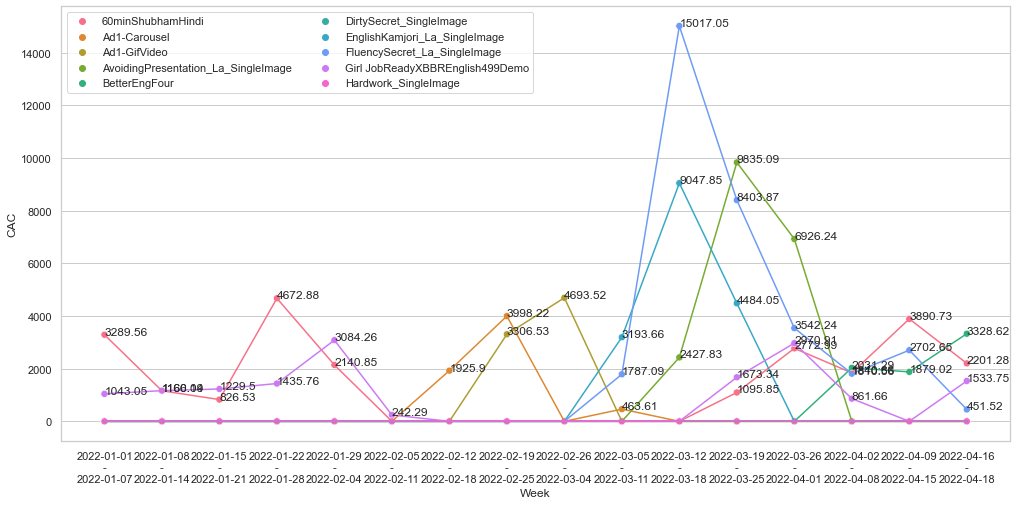

In [28]:
print("Median Val - ", cac.stack().median())
cacp = cac.fillna(0).reset_index().melt('Ad name', var_name = 'Week', value_name = 'Value')
cacp['Week'] = cacp['Week'].apply(lambda x : x.replace(" ", "\n"))
_=cacp[cacp['Ad name'].isin([ad_index[i] for i in req_col])]
plt.grid(visible=None, axis = 'x')
sns.lineplot(data = _, x = 'Week', y = 'Value', hue = 'Ad name', legend = False)
sns.scatterplot(data = _, x = 'Week', y = 'Value', hue = 'Ad name', s = 50)
for name, week, value in zip(_['Ad name'], _['Week'], _['Value']):
    if value > 0:
        plt.text(week, value, round(value,2))
sns.set(rc = {'figure.figsize':(17,8)}, palette = "hls")
sns.set_style("whitegrid")
plt.ylabel('CAC')
plt.legend(ncol = 2)
plt.show()